In [1]:
!pip install nltk

In [2]:
!pip install camel-tools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 10.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.8 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 9.2 MB/s eta 0:00:00
  Created wheel for camel-kenlm: filename=camel_kenlm-2024.5.6-cp310-cp310-linux_x86_64.whl size=592949 sha256=888bc0bfbd848efd2c01cb04630bdeb25cb6fb05745efc1153feb29ecc83af0b
  Stored in directory: /root/.cache/pip/wheels/2b/93/ff/ac84dae74c91ffe3e1c344a71f991946eacc79eada61cb703f
Successfully built camel-kenlm


In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp
import re
import matplotlib.pyplot as plt

# Ensure GPU usage if available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Download stopwords and punkt for tokenization
nltk.download('stopwords')
nltk.download('punkt')

# Set Arabic stopwords
#try to remove the stopwords algorithm 
ar_stopwords = set(stopwords.words('arabic'))

# Initialize Arabic stemmer
stemmer = ISRIStemmer()

def clean_text(text):
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)  # Remove non-Arabic characters
    return text

def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    text = clean_text(text)
    tokens = word_tokenize(text)
    filtered_tokens = [stemmer.stem(word) for word in tokens if word not in ar_stopwords and not word.isdigit()]
    return ' '.join(filtered_tokens)

def parallel_preprocess(text_series, num_workers=mp.cpu_count()):
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        processed_text = list(executor.map(preprocess_text, text_series))
    return processed_text

# Load data with encoding handling
try:
    data = pd.read_csv('/kaggle/input/data-79/data_with_sh - data_with_sh.csv')
except UnicodeDecodeError:
    data = pd.read_csv('/kaggle/input/data-79/data_with_sh - data_with_sh.csv', encoding='latin1')

# Ensure all text entries are strings
for column in ['Headline', 'Correction_Article', 'Category', 'label']:
    data[column] = data[column].astype(str)

# Preprocess data: segmenting and tokenizing
data['Headline'] = parallel_preprocess(data['Headline'])

# Initialize tokenizer with a reduced vocabulary size
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(data['Headline'])
sequences = tokenizer.texts_to_sequences(data['Headline'])
x_data = pad_sequences(sequences, maxlen=300)

# Encode category labels
category_encoder = LabelEncoder()
y_category = category_encoder.fit_transform(data['Category'])

# Encode real/fake labels
real_fake_encoder = LabelEncoder()
y_real_fake = real_fake_encoder.fit_transform(data['label'])

# Calculate class weights for category
category_class_weights = compute_class_weight('balanced', classes=np.unique(y_category), y=y_category)
category_class_weight_dict = dict(enumerate(category_class_weights))

# Calculate class weights for real/fake
real_fake_class_weights = compute_class_weight('balanced', classes=np.unique(y_real_fake), y=y_real_fake)
real_fake_class_weight_dict = dict(enumerate(real_fake_class_weights))

# Split the data into training and testing sets for category
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(x_data, y_category, test_size=0.2, random_state=42)

# Split the data into training and testing sets for real/fake
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x_data, y_real_fake, test_size=0.2, random_state=42)

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
category_checkpoint = ModelCheckpoint('best_category_model.keras', monitor='val_loss', save_best_only=True)
real_fake_checkpoint = ModelCheckpoint('best_real_fake_model.keras', monitor='val_loss', save_best_only=True)

Num GPUs Available:  2
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
num_categories = len(np.unique(y_category))
category_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=300),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.02))),
    Dropout(0.4),  # Increased dropout rate
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.02))),
    Dropout(0.4),  # Increased dropout rate
    BatchNormalization(),
    Dense(num_categories, activation='softmax', kernel_regularizer=l2(0.02))
])

category_model.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the updated category model
category_model.fit(
    x_train_cat, y_train_cat, epochs=10, batch_size=64, validation_data=(x_test_cat, y_test_cat),
    class_weight=category_class_weight_dict, callbacks=[early_stopping, category_checkpoint])

# Load the best category model
category_model.load_weights('best_category_model.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.3191 - loss: 12.8763 - val_accuracy: 0.5288 - val_loss: 11.1044
Epoch 2/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.5040 - loss: 10.6012 - val_accuracy: 0.6555 - val_loss: 9.1384
Epoch 3/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.6432 - loss: 8.6914 - val_accuracy: 0.7171 - val_loss: 7.4439
Epoch 4/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.7191 - loss: 7.0602 - val_accuracy: 0.7786 - val_loss: 6.0441
Epoch 5/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.7783 - loss: 5.7167 - val_accuracy: 0.8218 - val_loss: 4.8753
Epoch 6/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.8125 - loss: 4.6153 - val_accuracy: 0.8467 - val_loss: 3.9223
Epoch 7/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.8410 - loss: 3.7116 - val_accuracy: 0.8639 - val_loss: 3.1695
Epoch 8/10
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.861

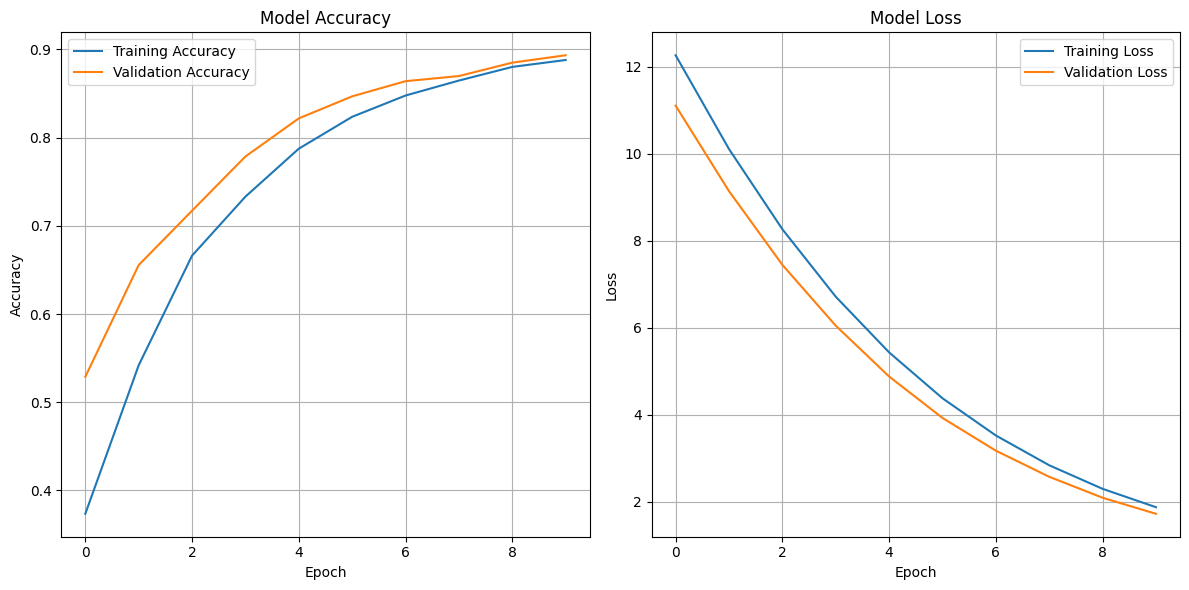

In [19]:
import matplotlib.pyplot as plt


# Plot learning curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(category_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(category_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(category_model.history.history['loss'], label='Training Loss')
plt.plot(category_model.history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [54]:
import numpy as np
import tensorflow as tf
import random

# Set the seed for numpy, random, and tensorflow
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Build a model for real/fake classification
real_fake_model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=300),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),  # Added L2 regularization
    Dropout(0.6),
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))),  # Added L2 regularization
    Dropout(0.6),
    BatchNormalization(),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))  # Added L2 regularization
])

real_fake_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the real/fake model using class weights with early stopping and checkpointing
real_fake_model.fit(x_train_rf, y_train_rf, epochs=5, batch_size=64, validation_data=(x_test_rf, y_test_rf), class_weight=real_fake_class_weight_dict,
                    callbacks=[early_stopping, real_fake_checkpoint])

# Load the best real/fake model
real_fake_model.load_weights('best_real_fake_model.keras')

Epoch 1/5
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.8186 - loss: 4.4210 - val_accuracy: 0.9504 - val_loss: 1.0544
Epoch 2/5
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.9511 - loss: 0.7934 - val_accuracy: 0.9611 - val_loss: 0.3474
Epoch 3/5
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.9632 - loss: 0.3047 - val_accuracy: 0.9595 - val_loss: 0.2588


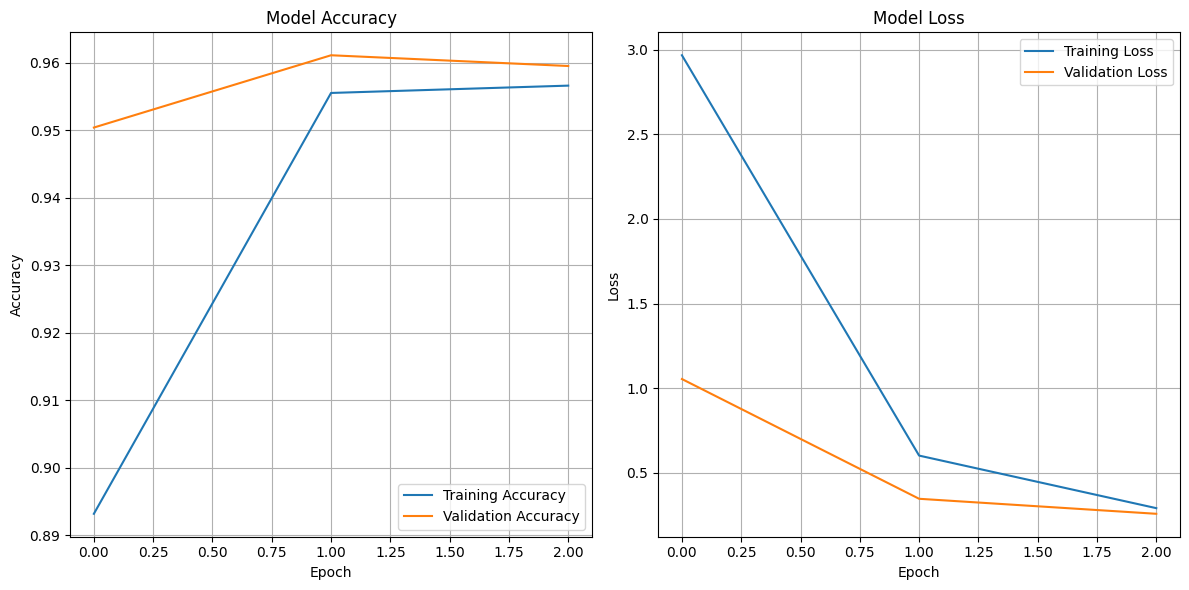

In [55]:
import matplotlib.pyplot as plt


# Plot learning curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(real_fake_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(real_fake_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(real_fake_model.history.history['loss'], label='Training Loss')
plt.plot(real_fake_model.history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [56]:
# Evaluate the category model
y_pred_cat = category_model.predict(x_test_cat)
y_pred_cat_classes = np.argmax(y_pred_cat, axis=1)

# Evaluate the real/fake model
y_pred_rf = real_fake_model.predict(x_test_rf)
y_pred_rf_classes = (y_pred_rf > 0.5).astype(int).reshape(-1)

# Generate classification reports
category_report = classification_report(y_test_cat, y_pred_cat_classes, target_names=category_encoder.classes_, output_dict=True)
real_fake_report = classification_report(y_test_rf, y_pred_rf_classes, target_names=['Fake', 'Real'], output_dict=True)

# Extract metrics for category classification
category_accuracy = category_report['accuracy']
category_precision = category_report['macro avg']['precision']
category_recall = category_report['macro avg']['recall']
category_f1_score = category_report['macro avg']['f1-score']

# Extract metrics for real/fake classification
real_fake_accuracy = real_fake_report['accuracy']
real_fake_precision = real_fake_report['macro avg']['precision']
real_fake_recall = real_fake_report['macro avg']['recall']
real_fake_f1_score = real_fake_report['macro avg']['f1-score']

# Create a DataFrame to display the results in a table-like format
results = pd.DataFrame({
    'RNN Model': ['Category Classification', 'Real/Fake Classification'],
    'Accuracy': [category_accuracy * 100, real_fake_accuracy * 100],
    'Precision': [category_precision, real_fake_precision],
    'Recall': [category_recall, real_fake_recall],
    'F1-Score': [category_f1_score, real_fake_f1_score]
})

# Set the index to the RNN Model column for better readability
results.set_index('RNN Model', inplace=True)

# Print the results DataFrame
print(results)

511/511 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step
511/511 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step
                           Accuracy  Precision    Recall  F1-Score
RNN Model                                                         
Category Classification   89.331620   0.885734  0.894597  0.888891
Real/Fake Classification  97.178357   0.971430  0.971468  0.971449


In [57]:
# Function to preprocess and predict the news text
def predict_news(text):
    segmented_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([segmented_text])
    padded_sequence = pad_sequences(sequence, maxlen=300)

    # Predict category
    category_probs = category_model.predict(padded_sequence)[0]
    category_index = np.argmax(category_probs)
    category = category_encoder.inverse_transform([category_index])[0]

    # Predict real/fake
    real_fake_prob = real_fake_model.predict(padded_sequence)[0][0]
    real_fake = "Real" if real_fake_prob < 0.5 else "Fake"

    return category, real_fake

# Loop to process user input
while True:
    user_input = input("Please enter a news piece in Arabic (type 'exit' to finish): ")
    if user_input.lower() == 'exit':
        break
    category, real_fake = predict_news(user_input)
    print(f"The news is predicted as: {real_fake}")
    print(f"The news category is: {category}")

Please enter a news piece in Arabic (type 'exit' to finish):  سرقة أسرار أوبن إيه آي تعزز المخاوف من الذكاء الاصطناعي


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
The news is predicted as: Real
The news category is: تكنولوجيا


Please enter a news piece in Arabic (type 'exit' to finish):  ثقافة كهوية مدينة.. "أصيلة" المغربية تحتضن موسمها الثقافي الدولي الـ45


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
The news is predicted as: Real
The news category is: ثقافة وفن


Please enter a news piece in Arabic (type 'exit' to finish):  9 أشهر من الشهادة واللهب.. مخاض دموي لعالم ما بعد طوفان الأقصى


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The news is predicted as: Real
The news category is: سياسة


Please enter a news piece in Arabic (type 'exit' to finish):  تتداول صفحات وحسابات على مواقع التواصل الاجتماعي، حديثًا، مقطع فيديو ادّعى ناشروه أنّه يظهر جمهور نادي الصفا السعودي بعد فرض السلطات عقوبات على إدارته واعتقال عدد من مشجعي النادي وإحالة آخرين للتحقيق.  ويُسمع في الفيديو هتاف المشجعين بالقول “علي والينا وهو حامي الحما”، وقال ناشرو الادعاء إن الهتاف جاء تحديًّا للسلطات السعودية بسبب العقوبات.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The news is predicted as: Fake
The news category is: سياسة


Please enter a news piece in Arabic (type 'exit' to finish):  تتداول حسابات على مواقع التواصل الاجتماعي، مقطع فيديو ادّعى ناشروه أنّه حديث وأنّ رئيس النظام السوري بشار الأسد يعلن فيه عن مصالحة وطنية وعن إصدار عفو عام عن المعتقلين


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The news is predicted as: Fake
The news category is: سياسة


Please enter a news piece in Arabic (type 'exit' to finish):  هكذا أسهمت قارورة بيكفورد السحرية في تأهل إنجلترا لنصف نهائي يورو 2024


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
The news is predicted as: Real
The news category is: رياضة


Please enter a news piece in Arabic (type 'exit' to finish):  الحرب الصليبية المنسية.. يوم أُبيد المسلمون في البلقان


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
The news is predicted as: Real
The news category is: ثقافة وفن


Please enter a news piece in Arabic (type 'exit' to finish):  أنصار مارسيليا يطلقون حملة رفضا لضم غرينوود


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
The news is predicted as: Real
The news category is: تكنولوجيا


Please enter a news piece in Arabic (type 'exit' to finish):  6 نقاط رئيسية من المحادثات الوزارية لدول شرق أفريقيا في زنجبار


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
The news is predicted as: Fake
The news category is: سياسة


Please enter a news piece in Arabic (type 'exit' to finish):  شاهد.. روبوتات بالذكاء الاصطناعي تواجه بها الشركات نقص الأيدي العاملة


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
The news is predicted as: Real
The news category is: تكنولوجيا


Please enter a news piece in Arabic (type 'exit' to finish):  exit
